# Prelude

In [1]:
# Enable interactive plots (%matplotlib -l to list backends)
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from bgcellmodels.common import analysis, signal, units, morphology, treeutils
from bgcellmodels.mechanisms import noise, synapses

import neuron; h = neuron.h
import bluepyopt.ephys as ephys

# print code version (hash of checked out version)
print("\nCurrent commit:")
!git log -1
# print("\nChanges since last commit:")
# !git status --short

# print date and time of script execution
import datetime
print("\nNotebook executed at at {} in following directory:".format(datetime.datetime.now()))
%cd ..


Current commit:
commit 73a20e6ff50ab8dfd379e1a79f902e2b64fc9bd1 (HEAD -> nothreadsafe, origin/nothreadsafe)
Author: Lucas Koelman <lucas.koelman@gmail.com>
Date:   Thu Sep 13 22:57:23 2018 +0100

    Fix bugs + WIP: calibrate full network

Notebook executed at at 2018-09-14 14:16:27.777183 in following directory:
/Users/luye/Workspace/bgcellmodels/bgcellmodels/models/GPe/Fujita2011


# Create cell

In [2]:
# Use GPe cell class used by PyNN
# import bgcellmodels.models.GPe.Fujita2011.fujita_pynn_model as fujita
# cell = fujita.GpeProtoType.model(**fujita.GpeProtoType.default_parameters)
# icell = cell.icell

import bgcellmodels.models.GPe.Fujita2011.fujita_model as fujita
icell = h.FujitaGPE() # new instance of cell template
icell.setparams_corbit_2016()

0.0

In [3]:
somatic = list(icell.somatic)
dendritic = list(icell.basal)
axonal = list(icell.axonal)

soma = somatic[0]
# axon = axonal[0]
# dend = dendritic[0]

# STN Afferents

## Experimental Data

The article by <span style='color:blue;font-weight:bold'> Kita & Kitai (1991) </span> about GP physiology shows EPSPs triggered by STN stimulation in Figure 7:

- the long responses in figures A and B are not EPSPs, but IPSPs with reversed polarity because the cell was hyperpolarized below the reversal potential for GABA
- in **Fig. D, bottom trace** we see a large, long-duration EPSP likely triggered by multiple spikes and concurrent AMPA + NMDA receptor activations
    + EPSP with amplitude of 25 mV (deviation from baseline)
    + tau_rise ~= 5 ms
    + tau_decay ~= 16.5 ms
- In **Fig. A, top trace** we see a small-amplitude short EPSP before the longer-duration IPSP

The article by <span style='color:blue;font-weight:bold'> Hanson & Jaeger (2002) </span> shows EPSPs and the time course for short-term facilitation & depression in Figure 1.
- Fig. 1C, right panel shows STD effect on short time scale, and left panel on longer time scale

## Calibration Results

Multi-synapse rule of 3 synapses each with a synaptic conductance of 0.05 nS yields a PSP of the desired magnitude.

## STN -> GPE.Proto (GLU)

In [4]:
# Calibrate AMPA synapse to get desired PSP time course

# Save inputs
stim_data = {}
istim = None

def make_stn_afferents(segments, rate=50, noise=0, num_spikes=1e9, tstart=750, 
                       gsyn_base=4.6e-5, scale_gsyn=1.0, scale_nmda=0.25,
                       intraburst_rate=0, interburst_interval=200, 
                       burst_duration=50.0, burst_noise=1.0):
    # Clear previous inputs
    stim_data['STN'] = {}
    stim_data['STN']['synapses'] = []
    stim_data['STN']['netstims'] = []
    stim_data['STN']['netcons'] = []
    
    if isinstance(tstart, (float, int)):
        tstart = [tstart]*len(segments)
    
    # Make new inputs
    for i, seg in enumerate(segments):
        syn = h.GLUsyn(seg)
        stim_data['STN']['synapses'].append(syn)
        
        # One spike generator for background spikes
        stim = h.NetStim()
        stim.interval = rate**-1*1e3
        stim.number = num_spikes
        stim.noise = noise
        stim.start = tstart[i]
        
        nc = h.NetCon(stim, syn)
        nc.delay = 1.0
        nc.weight[0] = 1.0
        
        stim_data['STN']['netstims'].append(stim)
        stim_data['STN']['netcons'].append(nc)
        
        # One spike generator for bursts (does not spike between bursts)
        if intraburst_rate != 0:
            bstim = h.BurstStim()
            bstim.fast_invl = intraburst_rate ** -1 * 1e3
            bstim.slow_invl = interburst_interval
            bstim.burst_len = burst_duration * 1e-3 * intraburst_rate
            bstim.start = tstart[i]
            bstim.noise = burst_noise
            
            bnc = h.NetCon(bstim, syn)
            bnc.delay = 1.0
            bnc.weight[0] = 1
            
            stim_data['STN']['netstims'].append(bstim)
            stim_data['STN']['netcons'].append(bnc)
        
        # Common STP parameters
        syn.tau_rec = 200.0
        syn.tau_facil = 800.0
        syn.U1 = P_release = 0.1
        
        # AMPA synapse parameters
        syn.gmax_AMPA = gAMPA = gsyn_base * scale_gsyn
        syn.tau_r_AMPA = 1.0
        syn.tau_d_AMPA = 4.0

        # NMDA synapse parameters
        syn.gmax_NMDA = scale_nmda * gAMPA
        syn.tau_r_NMDA = 3.7
        syn.tau_d_NMDA = 80

In [13]:
stim_data = {}
istim = None

h.distance(0, 0.5, sec=soma)
can_have_synapse = lambda seg: h.distance(1, seg.x, sec=seg.sec) > 2.0

# Multi-synapse calibration
make_stn_afferents([soma(0.5) for i in range(5)],
                   gsyn_base=5e-4, scale_gsyn=1.0,
                   rate=22, noise=1, num_spikes=1e9,
                   tstart=750)

# Single synapse calibration
# make_stn_afferents((proximal_sec(0.5), middle_sec(0.5), distal_sec(0.5)),
#                    rate=20, noise=0, num_spikes=100,
#                    tstart=[750+i*600 for i in range(3)])

# Disable spiking for more accurate PSP measurement
# for sec in h.allsec():
#     sec.gmax_NaF = 0.0

# Alternative to disable spiking: hyperpolarizing current (like in article figure)
surf_factor = 0.01

istim = h.IClamp(soma(0.5))
istim.delay = 250
istim.dur = 1000
istim.amp = -0.0 * surf_factor # 100 pA = 0.1 nA

<IPython.core.display.Javascript object>


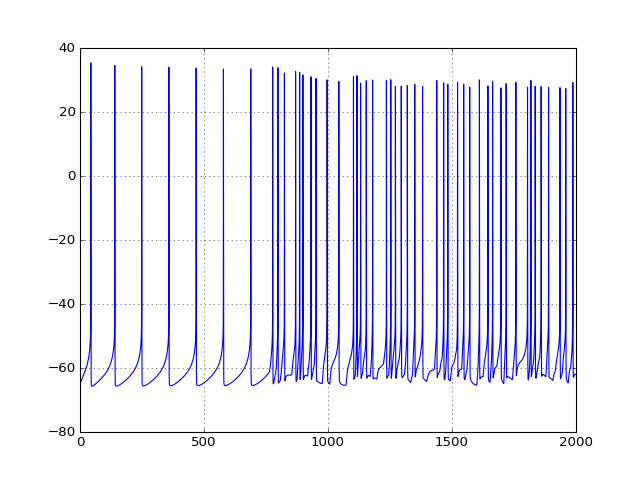

<IPython.core.display.Javascript object>


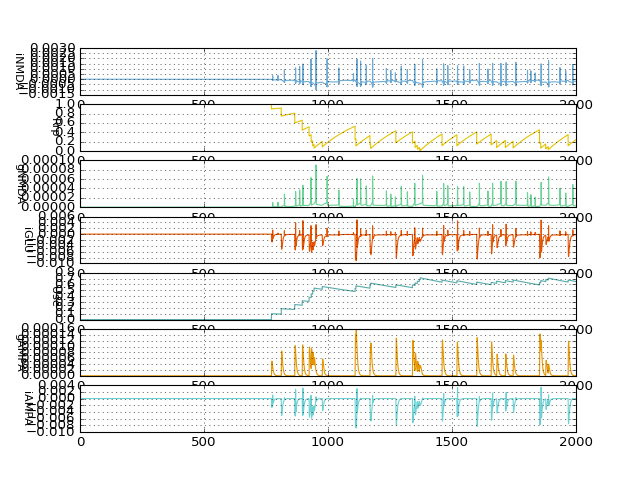

In [14]:
# Define traces
rec_secs = {
    'soma': soma,
    'synGLU': stim_data['STN']['synapses'][0],
}

trace_specs = {
    'V_soma': {'var':'v', 'sec':'soma', 'loc':0.5},
#     'V_prox': {'var':'v', 'sec':'prox', 'loc':0.5},
#     'V_mid': {'var':'v', 'sec':'mid', 'loc':0.5},
#     'V_dist': {'var':'v', 'sec':'dist', 'loc':0.5},
    # Synapse variables
    'gAMPA': {'pointp':'synGLU', 'var':'g_AMPA'},
    'gNMDA': {'pointp':'synGLU', 'var':'g_NMDA'},
    'iAMPA': {'pointp':'synGLU', 'var':'i_AMPA'},
    'iNMDA': {'pointp':'synGLU', 'var':'i_NMDA'},
    'iGLU': {'pointp':'synGLU', 'var':'i'},
    'Rrp': {'pointp':'synGLU', 'var':'R'},
    'Use': {'pointp':'synGLU', 'var':'Use'},
}

rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

# Init and run simulation
h.dt = 0.025
h.celsius = 35.0
h.v_init = -65.0
h.tstop = 2000.0
# h.init()
h.run()

# Plot recorded traces
plt.figure()
vrec_soma = vec_dict.pop('V_soma')
v_soma = vrec_soma.as_numpy()
t_soma = np.arange(len(v_soma)) * rec_dt
plt.plot(t_soma, v_soma)
plt.grid(True)

figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True) # yRange=(-80,40),

# GPE Afferents

## Experimental Data

For **GABA-B** receptors, the article by [Wu et al. (2005)](http://jpet.aspetjournals.org/content/312/3/1082) indicates that the component of the IPSC resulting from GABA-B receptors is about 15-40% of that resulting from GABA-A (GABA-A blocked -> peak current reaches 15-40% of control condition) dependent on location (proximal vs distal)

For <span style='color:red;font-weight:bold'>STR->GPe</span> inhibitory synapses, the article by <span style='color:blue;font-weight:bold'> Levine, Hull, Buchwald (1974) </span> about GP physiology shows following values in Figure 1:

- average IPSP trace shows approx. 5 mV dip from baseline
- exponential time constant for rising (dipping) phase : 66.0 ms
- exponential time constant for recovery phase : 100.0 ms

For <span style='color:red;font-weight:bold'>STR->GPe</span> inhibitory synapses, the article by <span style='color:blue;font-weight:bold'> Miguelez et al. (2012) </span> shows the following:

- Fig. 1A: IPSC_1 @ 10Hz : amplitude ~= 325 pA
- Fig. 1A: IPSC_5 @ 10Hz : amplitude ~= 825 pA

For <span style='color:red;font-weight:bold'>GPE->GPe</span> inhibitory synapses, the article by <span style='color:blue;font-weight:bold'> Miguelez et al. (2012) </span> shows the following:

- Fig. 1C: IPSC_1 @ 10Hz : amplitude ~= 950 pA
- Fig. 1C: IPSC_4 @ 10Hz : amplitude ~= 600 pA
- Fig. 5Ba: IPSC_1 in control condition : amplitude ~= 356 pA
- Fig. 5Bb: IPSC_1 in Parkinsonian condition : amplitude ~= 666 pA

## Calibration Results

- speculative calibration
    - `g_GABAA = 1e-3` and `g_GABAB = 0.25*g_GABAA` (GLUsynTM2 mechanism) yields ~ 20 mV dip
    - this can be assumed to be close to `gtot` where a large fraction of GABAergic afferents are activated
    - so we can divide this number by the number of simulated synapses => `gsyn = 1e-3 / n_syn`

- Calibration with only 25 STN contacts + 12 GPe contacts in GPe Arky cell
    + `gmax_GABAA = 8.333e-5`
    + `gmax_GABAB = 0.25 * gmax_GABAA`

## GPE.all -> GPE.Proto (GABA)

In [15]:
# Save inputs
stim_data = {}
istim = None

def make_gpe_afferents(segments, rate=50, noise=0, num_spikes=1e9, tstart=750, 
                       gsyn_base=1e-4, scale_gsyn=1.0, 
                       intraburst_rate=0, interburst_interval=200, 
                       burst_duration=50.0, burst_noise=1.0):
    # Clear previous inputs
    stim_data['GPE'] = {}
    stim_data['GPE']['synapses'] = []
    stim_data['GPE']['netstims'] = []
    stim_data['GPE']['netcons'] = []
    
    if isinstance(tstart, (float, int)):
        tstart = [tstart]*len(segments)
    
    # Make new inputs
    for i, seg in enumerate(segments):
        syn = h.GABAsynTM2(seg)
        stim_data['GPE']['synapses'].append(syn)
        
        # One spike generator for background spikes
        stim = h.NetStim()
        stim.interval = rate**-1*1e3
        stim.number = num_spikes
        stim.noise = noise
        stim.start = tstart[i]
        
        nc = h.NetCon(stim, syn)
        nc.delay = 1.0
        nc.weight[0] = 1.0
        
        stim_data['GPE']['netstims'].append(stim)
        stim_data['GPE']['netcons'].append(nc)
        
        # One spike generator for bursts (does not spike between bursts)
        if intraburst_rate != 0:
            bstim = h.BurstStim()
            bstim.fast_invl = intraburst_rate ** -1 * 1e3
            bstim.slow_invl = interburst_interval
            bstim.burst_len = burst_duration * 1e-3 * intraburst_rate
            bstim.start = tstart[i]
            bstim.noise = burst_noise
            
            bnc = h.NetCon(bstim, syn)
            bnc.delay = 1.0
            bnc.weight[0] = 1
            
            stim_data['GPE']['netstims'].append(bstim)
            stim_data['GPE']['netcons'].append(bnc)
        
        # GABA-A synapse parameters
        syn.tau_rec_A = 400.0
        syn.tau_facil_A = 1.0
        syn.U1_A = P_release = 0.2 # release probability
        syn.gmax_GABAA = gGABAA = gsyn_base * scale_gsyn # gmax is in [uS]
        syn.tau_r_GABAA = 2.0
        syn.tau_d_GABAA = 5.0

        # GABA-B synapse parameters
        syn.tau_rec_B = 300.0
        syn.tau_facil_B = 300.0
        syn.U1_B = 0.05 # release probability
        syn.gmax_GABAB = 0.25 * gGABAA
        syn.tau_r_GABAB = 5.0 # initial species of signaling cascade
        syn.tau_d_GABAB = 50.0 # initial species of signaling cascade

In [22]:
# Clear existing inputs
stim_data = {}
istim = None
hpwa = None

# Single synapse calibration
make_gpe_afferents([soma(0.5) for i in range(3)],
                   gsyn_base=1e-4, scale_gsyn=4,
                   rate=60, noise=0, num_spikes=100,
                   tstart=[750+i*600 for i in range(3)])

# Disable spiking for more accurate PSP measurement
# for sec in h.allsec():
#     sec.gmax_NaF = 0.0

# Alternative to disable spiking: hyperpolarizing current (like in article figure)
surf_factor = 0.01

istim = h.IClamp(soma(0.5))
istim.delay = 250
istim.dur = 1000
istim.amp = 0.0 * surf_factor # 100 pA = 0.1 nA

In [23]:
# Define traces
rec_secs = {
    'soma': soma,
    'synGABA': stim_data['GPE']['synapses'][0],
}

trace_specs = {
    'V_soma': {'var':'v', 'sec':'soma', 'loc':0.5},
#     'V_prox': {'var':'v', 'sec':'prox', 'loc':0.5},
#     'V_mid': {'var':'v', 'sec':'mid', 'loc':0.5},
#     'V_dist': {'var':'v', 'sec':'dist', 'loc':0.5},
    'gGABAA': {'pointp':'synGABA', 'var':'g_GABAA'},
    'gGABAB': {'pointp':'synGABA', 'var':'g_GABAB'},
    'Rrp': {'pointp':'synGABA', 'var':'Rrp_B'},
    'Use': {'pointp':'synGABA', 'var':'Use_B'},
    'Itot': {'pointp':'synGABA', 'var':'i'},
    'gtot' : {'pointp':'synGABA', 'var':'g'},
}

rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

# Init and run simulation
h.dt = 0.025
h.celsius = 35.0
h.v_init = -68.0
h.tstop = 2000.0
# h.init()
h.run()

0.0

<IPython.core.display.Javascript object>


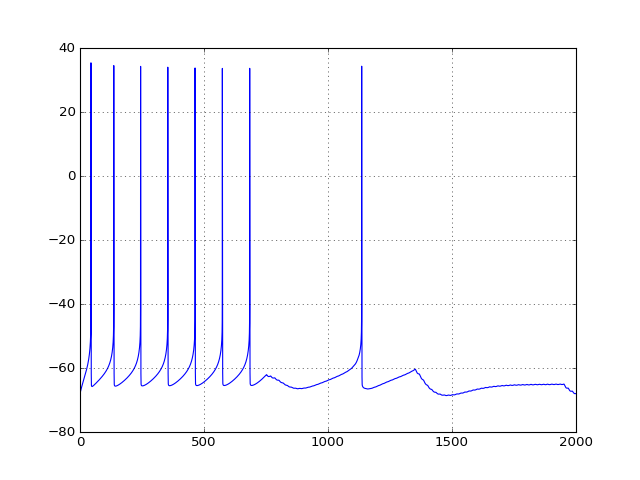

<IPython.core.display.Javascript object>


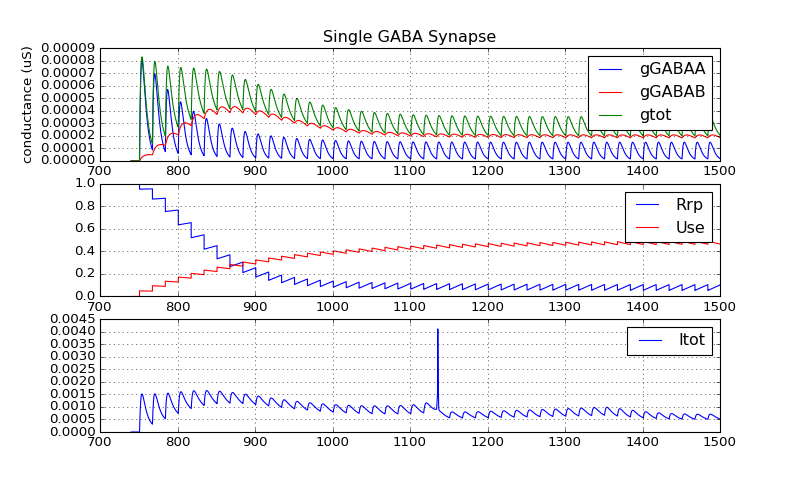

In [24]:
# Plot recorded traces
plt.figure()
vrec_soma = vec_dict.pop('V_soma')
v_soma = vrec_soma.as_numpy()
t_soma = t_rec = np.arange(len(v_soma)) * rec_dt
plt.plot(t_soma, v_soma)
plt.grid(True)

# Plot GABAsyn variables automatically
#figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True) # yRange=(-80,40),

# Plot GABAsyn variables manually
fig, axes = plt.subplots(3, 1, figsize=(10,6))
interval = (740, 1500)
a = int(interval[0] // rec_dt)
b = int(interval[1] // rec_dt)
t_plot = t_rec[a:b]

ax = axes[0]
ax.plot(t_plot, vec_dict['gGABAA'].as_numpy()[a:b], 'b', label='gGABAA')
ax.plot(t_plot, vec_dict['gGABAB'].as_numpy()[a:b], 'r', label='gGABAB')
ax.plot(t_plot, vec_dict['gtot'].as_numpy()[a:b], 'g', label='gtot')
ax.set_ylabel('conductance (uS)')
ax.legend()
ax.grid(True)
ax.set_title('Single GABA Synapse')

ax = axes[1]
ax.plot(t_plot, vec_dict['Rrp'].as_numpy()[a:b], 'b', label='Rrp')
ax.plot(t_plot, vec_dict['Use'].as_numpy()[a:b], 'r', label='Use')
ax.grid(True)
ax.legend()

ax = axes[2]
ax.plot(t_plot, vec_dict['Itot'].as_numpy()[a:b], 'b', label='Itot')
ax.grid(True)
ax.legend()

# STR.MSN Afferents

## Experimental Data

For <span style='color:red;font-weight:bold'>STR->GPe</span> inhibitory synapses, the article by <span style='color:blue;font-weight:bold'> Levine, Hull, Buchwald (1974) </span> about GP physiology shows following values in Figure 1:

- average IPSP trace shows approx. 5 mV dip from baseline
- exponential time constant for rising (dipping) phase : 66.0 ms
- exponential time constant for recovery phase : 100.0 ms

For <span style='color:red;font-weight:bold'>STR->GPe</span> inhibitory synapses, the article by <span style='color:blue;font-weight:bold'> Miguelez et al. (2012) </span> shows the following:

- Fig. 1A: IPSC_1 @ 10Hz : amplitude ~= 325 pA
- Fig. 1A: IPSC_5 @ 10Hz : amplitude ~= 825 pA


## Calibration Results

- to match facilitation in Miguelez (2012), Fig 1.A, following params work:
    + `U1 = 0.05`
    + `tau_facil = 100`
    + `tau_rec = 1`

## STR.MSN -> GPE.Proto (GABA)

In [25]:
# Save inputs
stim_data = {}
istim = None

def make_str_afferents(segments, rate=50, noise=0, num_spikes=1e9, tstart=750, 
                       gsyn_base=1e-4, scale_gsyn=1.0, intraburst_rate=0, interburst_interval=200, 
                       burst_duration=50.0, burst_noise=1.0):
    # Clear previous inputs
    stim_data['STR'] = {}
    stim_data['STR']['synapses'] = []
    stim_data['STR']['netstims'] = []
    stim_data['STR']['netcons'] = []
    
    if isinstance(tstart, (float, int)):
        tstart = [tstart]*len(segments)
    
    # Make new inputs
    for i, seg in enumerate(segments):
        syn = h.GABAAsynTM(seg)
        stim_data['STR']['synapses'].append(syn)
        
        # One spike generator for background spikes
        stim = h.NetStim()
        stim.interval = rate**-1*1e3
        stim.number = num_spikes
        stim.noise = noise
        stim.start = tstart[i]
        
        nc = h.NetCon(stim, syn)
        nc.delay = 1.0
        nc.weight[0] = 1.0
        
        stim_data['STR']['netstims'].append(stim)
        stim_data['STR']['netcons'].append(nc)
        
        # One spike generator for bursts (does not spike between bursts)
        if intraburst_rate != 0:
            bstim = h.BurstStim()
            bstim.fast_invl = intraburst_rate ** -1 * 1e3
            bstim.slow_invl = interburst_interval
            bstim.burst_len = burst_duration * 1e-3 * intraburst_rate
            bstim.start = tstart[i]
            bstim.noise = burst_noise
            
            bnc = h.NetCon(bstim, syn)
            bnc.delay = 1.0
            bnc.weight[0] = 1
            
            stim_data['STR']['netstims'].append(bstim)
            stim_data['STR']['netcons'].append(bnc)
        
        # Common Synapse parameters
        syn.tau_rec = 1.0
        syn.tau_facil = 200.0
        syn.U1 = P_release = 0.05 # release probability

        # GABA-A synapse parameters
        syn.gmax_GABAA = gsyn_base * scale_gsyn
        syn.tau_r_GABAA = 2.0
        syn.tau_d_GABAA = 5.0

In [32]:
# Clear existing inputs
stim_data = {}
istim = None
hpwa = None

# Single synapse calibration
make_str_afferents([soma(0.5) for i in range(3)],
                   gsyn_base=1e-3, scale_gsyn=1.0,
                   rate=60, noise=0, num_spikes=100,
                   tstart=[750+i*600 for i in range(3)])

# Disable spiking for more accurate PSP measurement
# for sec in h.allsec():
#     sec.gmax_NaF = 0.0

# Alternative to disable spiking: hyperpolarizing current (like in article figure)
surf_factor = 0.01

istim = h.IClamp(soma(0.5))
istim.delay = 250
istim.dur = 1000
istim.amp = 0.0 * surf_factor # 100 pA = 0.1 nA

In [33]:
# Define traces
rec_secs = {
    'soma': soma,
    'synGABA': stim_data['STR']['synapses'][0],
}

trace_specs = {
    'V_soma': {'var':'v', 'sec':'soma', 'loc':0.5},
#     'V_prox': {'var':'v', 'sec':'prox', 'loc':0.5},
#     'V_mid': {'var':'v', 'sec':'mid', 'loc':0.5},
#     'V_dist': {'var':'v', 'sec':'dist', 'loc':0.5},
    'gGABAA': {'pointp':'synGABA', 'var':'g_GABAA'},
    'Rrp': {'pointp':'synGABA', 'var':'Rrp'},
    'Use': {'pointp':'synGABA', 'var':'Use'},
    'Itot': {'pointp':'synGABA', 'var':'i'},
    'gtot' : {'pointp':'synGABA', 'var':'g'},
}

rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

# Init and run simulation
h.dt = 0.025
h.celsius = 35.0
h.v_init = -68.0
h.tstop = 2000.0
# h.init()
h.run()

0.0

<IPython.core.display.Javascript object>


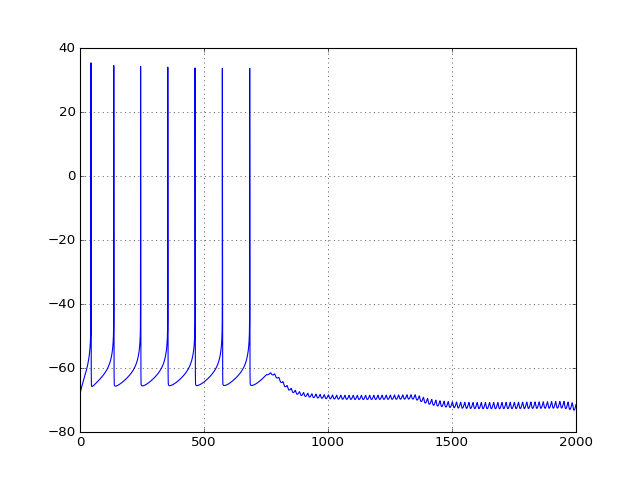

<IPython.core.display.Javascript object>


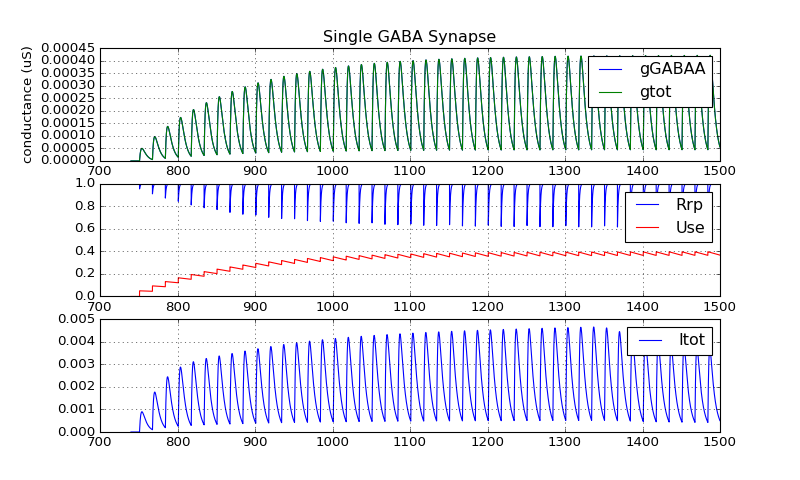

In [34]:
# Plot recorded traces
plt.figure()
vrec_soma = vec_dict.pop('V_soma')
v_soma = vrec_soma.as_numpy()
t_soma = t_rec = np.arange(len(v_soma)) * rec_dt
plt.plot(t_soma, v_soma)
plt.grid(True)

# Plot GABAsyn variables automatically
#figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True) # yRange=(-80,40),

# Plot GABAsyn variables manually
fig, axes = plt.subplots(3, 1, figsize=(10,6))
interval = (740, 1500)
a = int(interval[0] // rec_dt)
b = int(interval[1] // rec_dt)
t_plot = t_rec[a:b]

ax = axes[0]
ax.plot(t_plot, vec_dict['gGABAA'].as_numpy()[a:b], 'b', label='gGABAA')
ax.plot(t_plot, vec_dict['gtot'].as_numpy()[a:b], 'g', label='gtot')
ax.set_ylabel('conductance (uS)')
ax.legend()
ax.grid(True)
ax.set_title('Single GABA Synapse')

ax = axes[1]
ax.plot(t_plot, vec_dict['Rrp'].as_numpy()[a:b], 'b', label='Rrp')
ax.plot(t_plot, vec_dict['Use'].as_numpy()[a:b], 'r', label='Use')
ax.grid(True)
ax.legend()

ax = axes[2]
ax.plot(t_plot, vec_dict['Itot'].as_numpy()[a:b], 'b', label='Itot')
ax.grid(True)
ax.legend()

# ALL Afferents

The Observations Database contains following observations that may help in configuring the distribution of synapses on the GPe dendritic tree:

## Calibration Data

### Firing Pattern

- firing rate
    + for prototypic GPe cells, the mean firing rate is <span style='color:blue;font-weight:bold'> 47.4 +/- 6.1 Hz </span>
    + for arkypallidal GPe cells, the mean firing rate is 8.9 +/- 1.9 Hz
    + in general firing rate of GPe cells has been reported between 50-70 Hz, and between 20-100 Hz



### GPe Synapse Information

_Steiner, Tseng (2017) Chapter 13, p 268_

>  Sadek
et al. (2007) examined local collaterals of GPe neurons
exhibiting high-frequency firing in anesthetized rats
using the juxtacellular labeling method. They found that
the local axon collaterals formed multiple arborizations;
one close to, or within, the parent dendritic field and
others caudal, medial, and ventral to the parent neuron
(Fig. 13.7). The neurons in the border region (see
Section II.A) had an average of 264 boutons, and those
in more medial regions had an average of 581 boutons.
Mallet et al. (2012) found that PV+ neurons in rat GPe
have on average longer collaterals with a larger number
of boutons than arkypallidal neurons, namely 468 versus
120 boutons. Although the number of boutons formed
by collateral axons is small, they form synapses on the
somata and proximal dendrites and can generate strong
synaptic inputs to control spiking activity.

- Average number of boutons per efferent axon (collateral) that arborize in the medial region of the origin GPe cell's dendritic field is <span style='color:blue;font-weight:bold'>581</span> [boutons/(axon*cell)]
    + i.e. number of _outgoing_ collateral boutons to nearby target cells


- Average number of boutons per efferent axon (collateral) that arborize in the border region of the origin GPe cell's dendritic field is <span style='color:blue;font-weight:bold'>264</span> [boutons/(axon*cell)]
    + i.e. number of _outgoing_ collateral boutons to neighboring cells that are slightly farther away
    + farther = target cell is in border region of origin cell's dendritic field


- Although the number of boutons formed by collateral axons is small, they form synapses on the somata and proximal dendrites and can generate strong synaptic inputs to control spiking activity.
    + Contacts of GPe synapses are larger/stronger than Striatal ones


- GPe presynaptic firing rate: use parameters above: <span style='color:blue;font-weight:bold'> 47.4 +/- 6.1 Hz </span>


### STN Synapse Information

> Koshimizu et al. (2013) found that in rats, each STN
axon forms an average of 457 and 106 boutons in GPe
and GPi, respectively. Oorschot (1996) estimated that
the rat GPe, GPi, and STN each contain 46,000, 3200,
and 13,600 neurons. These counts suggest that each
GPe and GPi neuron is innervated by 135 and 450 STN
boutons, respectively. These numbers are very small
compared to the estimate above in which each GPe
neuron is innervated by about 10,000 striatal boutons.
Although the numbers are relatively small, these syn-
aptic inputs may be able to trigger action potentials
(APs) by activating regenerative membrane currents of
distal dendrites (see Section IV.A). 

- number of synaptic boutons on GPe cells that come from STN afferents is <span style='color:blue;font-weight:bold'> 135</span>
    + ! this estimate is not an error -> it is mentioned that this is very low compared to the ~10.000 Striatal boutons


- STN pre-synaptic firing rate
    - mean discharge rate of STN neurons <span style='color:blue;font-weight:bold'> 20-25 Hz </span>
    - most STN neurons have a Poisson-like discharge rate with a slight tendency towards bursting


### Str Synapse Information

Steiner Tseng (20170 Ch. 12, p. 264

>  Striatal boutons (inclusive of axonal varicosities)
are small or medium in size (,1 µm), contain large
pleomorphic vesicles, and form synapses mainly
on the dendrites of GPe neurons (Fig. 13.4) (DiFiglia et al., 1982; Falls et al., 1983).
On average in the rat, the number of boutons in the GPe formed by
an axon of an indirect projection neuron is 226, and
those formed by a direct projection neuron is 123
(Kawaguchi et al., 1990). Assuming equal numbers of
indirect and direct striatal projection neurons, for a
total of 2,800,000 neurons projecting to 46,000 GPe neu-
rons in a rat (Oorschot, 1996), we can estimate that an
average of 10,622 striatal boutons terminate on each
GPe neuron.
Anterograde tracing studies revealed that striatal
axons form two disk-shaped terminal fields in both
GPe and GPi (Kaneda et al., 2002; Kita and Kita, 2001;
Wilson and Phelan, 1982). Single axon tracing studies in
rats and monkeys further revealed that these terminal
areas are created by each striatal axon forming multiple
narrow disk-shaped terminal fields (Fig. 13.1B) (Chang
et al., 1981; Kawaguchi et al., 1990; Kita, 1996; Parent
et al., 1995). Fig. 13.1D shows that neurons in the two
motor-related territories in primate putamen form mul-
tiple motor territories in the GPe and GPi. 

- Average number of striatal boutons per GPe cell is <span style='color:blue;font-weight:bold'>10622</span>
- Average number of boutons on one GPe cell coming from one axon belonging to a Striatal indirect pathway neuron is 226 [boutons/(axon*cell)]
- Average number of boutons on one GPe cell coming from one axon belonging to a Striatal direct pathway neuron is 123 [boutons/(axon*cell)]

- Str pre-synaptic firing rate
    + Str projection neurons (MSN/SPN) have a low firing rate (time-coding): <span style='color:blue;font-weight:bold'> < 1 Hz </span>


### Corbit (2017)

- 40 MSN cells
- 8 FSI cells
- 8 GPe cells

| Pre | Post | P_conn       | N_pre * P_conn   | gsyn (mS/cm2)| gtot  | tau_r | tau_d |
|-----|------|--------------|------------------|--------------|-------|-------|-------|
| MSN | GPE  | 37.5         | 15               | 0.07         | 1.05  | 0.5   | 12.5  |
| GPE | GPE  | 25           | 2                | 0.1          | 0.2   | 0.5   | 12.5  |


### Summary

Number of boutons per afferent population:

| GPe.clo | GPe.far | GPe.tot    | Str.D1 | Str.D2 | Str.tot | STN |
|---------|---------|------------|--------|--------|---------|-----|
| ???     | ???     | ???        | 3540   | 7081   | 10622   | 135 |

|           | GPe           | Str      | STN    |
|-----------|---------------|----------|--------|
| fraction  | ~20%          | ~75%     | 5%     |
| strength  | strong        | weak     | strong |
| locations | proximal+soma | proximal | distal |


Calculation of number of (simulated) synapses:

- __Striatum__ : 10622 [boutons] / 123-226 [boutons/(axon*cell)] = 47-86 [axons on one cell]
    + If we use additive property of Poisson distribution we can divide the number of synapses by N, with Poisson spike generators firing at `N*f_mean`
    + The caveat is that they won't have indendent STP properties per synapse

- __GPE__ : 2000 [boutons] / 264-581 [boutons/(axon*cell)] = 3.4-7.6 [axons on one cell]


- __STN__ : 135 [boutons] / ??? [boutons/(axon*cell)] = ??? [axons on one cell]

## Make Synapses

### ALL -> GPE.Proto (GABA+GLU)

In [49]:
# Clear old inputs
stim_data = {}
istim = None

# Parameters for afferents
# Set scale factors to 1 divided by number of co-activated contacts resulting in calibrated PSP
aff_par = {}

aff_par['STN'] = {}
aff_par['STN']['nsyn'] = NUM_PRE_STN = 5 # inputs * contacts, divergent pattern
aff_par['STN']['segs'] = [soma(0.5) for i in range(NUM_PRE_STN)]
aff_par['STN']['rate'] = RATE_STN = 22.5 # Bergman: 22.5+/-2.5 Hz, 50-70 when active, pauses of 100-600 ms
aff_par['STN']['gsyn_scale'] = 1.0
aff_par['STN']['gsyn_base'] = 10.5e-4


aff_par['GPE'] = {}
aff_par['GPE']['nsyn'] = NUM_PRE_GPE = 4 # inputs * contacts
aff_par['GPE']['segs'] = [soma(0.5) for i in range(NUM_PRE_GPE)]
aff_par['GPE']['rate'] = RATE_GPE = 0.33*8.9 + 0.66*47.5 # in between pauses
aff_par['GPE']['gsyn_scale'] = 1.0
aff_par['GPE']['gsyn_base'] = 1e-4


aff_par['STR'] = {}
aff_par['STR']['nsyn'] = NUM_PRE_STR = 30 # inputs * contacts
aff_par['STR']['segs'] = [soma(0.5) for i in range(NUM_PRE_STR)]
aff_par['STR']['rate'] = RATE_STR = 1.0 # CTL: 0-1 Hz, DD: 6.64+/-2.83 Hz
aff_par['STR']['gsyn_scale'] = 1.0
aff_par['STR']['gsyn_base'] = 1e-3



make_stn_afferents(aff_par['STN']['segs'], rate=aff_par['STN']['rate'],
                   gsyn_base=aff_par['STN']['gsyn_base'],
                   scale_gsyn=aff_par['STN']['gsyn_scale'],
                   noise=1.0, tstart=20)
#                    intraburst_rate=100, interburst_interval=500.0, 
#                    burst_duration=50.0, burst_noise=1.0)

make_gpe_afferents(aff_par['GPE']['segs'], rate=aff_par['GPE']['rate'],
                   gsyn_base=aff_par['GPE']['gsyn_base'],
                   scale_gsyn=aff_par['GPE']['gsyn_scale'],
                   noise=1.0, tstart=20)
#                    intraburst_rate=60, interburst_interval=250.0, 
#                    burst_duration=2500.0, burst_noise=1.0)

make_str_afferents(aff_par['STR']['segs'], rate=aff_par['STR']['rate'],
                   gsyn_base=aff_par['STR']['gsyn_base'],
                   scale_gsyn=aff_par['STR']['gsyn_scale'],
                   noise=1.0, tstart=20)

# Check that we have correct number of inputs
for pre in stim_data.keys():
    print("Afferents from {pre} have:\n\t- {nsyn} synapses"
          "\n\t- {nstim} spike generators".format(
              pre=pre, nsyn=len(stim_data[pre]['synapses']),
              nstim=len(stim_data[pre]['netstims'])))

Afferents from GPE have:
	- 4 synapses
	- 4 spike generators
Afferents from STN have:
	- 5 synapses
	- 5 spike generators
Afferents from STR have:
	- 30 synapses
	- 30 spike generators


### Weight Scaler

In [50]:
# Execute this cell to disable scaling
hpwa = None
fih = None

In [51]:
# Activity-dependent scaling of synaptic weights
from bgcellmodels.mechanisms import plasticity

# Clear old references
hpwa = None
rec_secs = None

hpwa = h.VanRossumHPWA(soma(0.5))
hpwa.scaling = 0
hpwa.sensing = 0
hpwa.activitytau = 1e3 # larger window if variable rate (10-100)
hpwa.activitybeta = 5e-1 # (s^-1 Hz^-1) Scaling strength proportional to activity error (was 4e-5 in article)
hpwa.set_target_rate(47.4) # SETPARAM: target rate

# Add weights to scale
# NOTE: we keep STN calibrated value, so we scale STR inputs
for syn in stim_data['STN']['synapses']:
    h.setpointer(syn._ref_gmax_AMPA, 'temp_wref', hpwa)
    hpwa.add_wref(1)
    h.setpointer(syn._ref_gmax_NMDA, 'temp_wref', hpwa)
    hpwa.add_wref(1)

# Set up activity sensing
spike_rec = h.NetCon(soma(0.5)._ref_v, hpwa, sec=soma)
spike_rec.threshold = 0.0
spike_rec.delay = 1
spike_rec.weight[0] = 1

# Enable plasticity after delay
cvode = h.CVode()
def enable_sensing():
    hpwa.sensing = 1
    print("Start sensing at time {}".format(h.t))
def enable_scaling():
    hpwa.scaling = 1 # SETPARAM: enable or disable scaling
    print("Start scaling at time {}".format(h.t))
def add_events():
    cvode.event(50.0, enable_sensing)
    cvode.event(4.0*hpwa.activitytau, enable_scaling)
fih = h.FInitializeHandler(add_events)

### Record & Run

In [52]:
# Define traces
rec_secs = {
    'soma': soma,
    'soma_spiker': h.NetCon(soma(0.5)._ref_v, None, -10.0, 0, 0),
    'hpwa': hpwa,
#     'prox': proximal_seg,
#     'mid': middle_seg,
#     'dist': distal_seg,
#     'synGABA': synapses[0],
}

trace_specs = {
    't_global': {'var': 't'},
    'V_soma': {'var':'v', 'sec':'soma', 'loc':0.5},
    'AP_soma': {'netcon': 'soma_spiker'},
    # HPWA weight scaling
    'a_HPWA': {'pointp':'hpwa', 'var':'activity'},
    'scale_HPWA': {'pointp':'hpwa', 'var':'scalefactor'},
    # STN Synapse variables
    'gAMPA_stn': {'pointp':'synSTN0', 'var':'g_AMPA'},
    'gNMDA_stn': {'pointp':'synSTN0', 'var':'g_NMDA'},
    'iAMPA_stn': {'pointp':'synSTN0', 'var':'i_AMPA'},
    'iNMDA_stn': {'pointp':'synSTN0', 'var':'i_NMDA'},
    'itot_stn':  {'pointp':'synSTN0', 'var':'i'},
    # GPE Synapse variables
    'gGABAA_gpe': {'pointp':'synGPE0', 'var':'g_GABAA'},
    'gGABAB_gpe': {'pointp':'synGPE0', 'var':'g_GABAB'},
    'iGABAA_gpe': {'pointp':'synGPE0', 'var':'i_GABAA'},
    'iGABAB_gpe': {'pointp':'synGPE0', 'var':'i_GABAB'},
    'itot_gpe':  {'pointp':'synGPE0', 'var':'i'},
}

# Record spikes at synapses
for pop in 'STN', 'GPE', 'STR':
    for i_syn, nc in enumerate(stim_data[pop]['netcons']):
        con_label = "con{}{}".format(pop, i_syn)
        syn_label = "syn{}{}".format(pop, i_syn)
        rec_secs[con_label] = nc
        rec_secs[syn_label] = nc.syn()
        trace_specs['AP_'+con_label] = {'netcon': con_label}
        trace_specs['i_'+syn_label] = {'pointp': syn_label, 'var':'i'}

# SETPARAM: low sampling interval for slow traces
rec_dt = 5.0 # .05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

In [53]:
# Init and run simulation
h.dt = 0.025
h.celsius = 35.0
h.v_init = -68.0
h.tstop = 30e3
#h.init()

import time
tstart = time.time()
h.run()

tstop = time.time()
cputime = tstop - tstart
num_segments = sum((sec.nseg for sec in h.allsec()))
print("Simulated {} segments for {} ms in {} ms CPU time".format(
        num_segments, h.tstop, cputime))

Start sensing at time 50.0
Start scaling at time 3999.99999998
Simulated 1 segments for 30000.0 ms in 16.0299921036 ms CPU time


## Plot & Analyze

### Plot Weight Scaling

Calibration results:
TODO

<IPython.core.display.Javascript object>


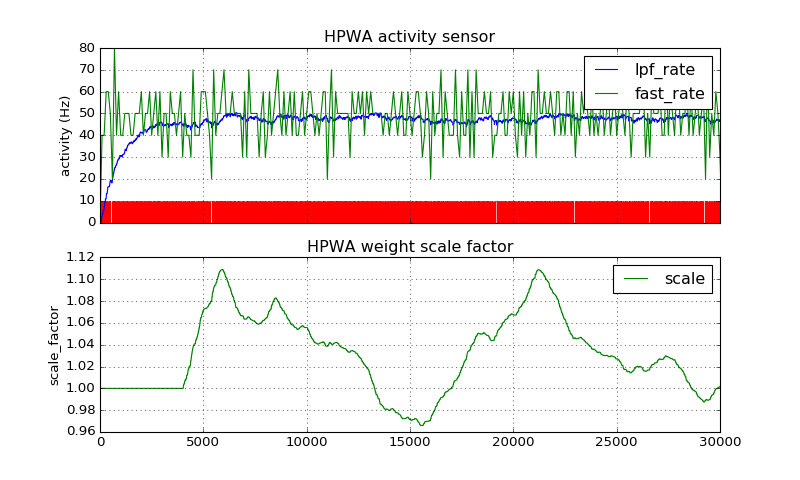

Final scale factor is: 1.00149048703
Final STN gmax_AMPA is 0.00105156501138
Final STN gmax_NMDA is 0.000262891252845
Final GPE gmax_GABAA is 0.0001
Final GPE gmax_GABAB is 2.5e-05
Final STR gmax_GABAA is 0.001


In [54]:
# Plot GLU synapse variables
fig, axes = plt.subplots(2, 1, figsize=(10,6), sharex=True)

# Signals
activity_hz = vec_dict['a_HPWA'].as_numpy() * 1e3
scale_vec = vec_dict['scale_HPWA'].as_numpy()
t_rec = np.arange(len(activity_hz)) * rec_dt

# Activity on faster time scale (want to know variability)
bin_width = 100.0
psth_vec = signal.nrn_avg_rate_simple([vec_dict['AP_soma'].as_numpy()], 0, h.tstop, bin_width)
psth_rate = psth_vec.as_numpy()

# Plotted interval
interval = (0.0, h.tstop)
a = int(interval[0] // rec_dt)
b = int(interval[1] // rec_dt)
t_plot = t_rec[a:b]

ax = axes[0]

ax.plot(t_rec, activity_hz, 'b', label='lpf_rate')
ax.plot(np.arange(psth_rate.size)*bin_width, psth_rate, 'g', label='fast_rate')
ax.vlines(vec_dict['AP_soma'].as_numpy(), 
        activity_hz.min(), 0.2*activity_hz.max(),
        color='red', linewidth=1.0)
ax.set_xlim((interval))
ax.set_ylabel('activity (Hz)')
ax.legend()
ax.grid(True)
ax.set_title('HPWA activity sensor')

ax = axes[1]
ax.plot(t_rec, scale_vec, 'g', label='scale')
ax.set_xlim((interval))
ax.set_ylabel('scale_factor')
ax.legend()
ax.grid(True)
ax.set_title('HPWA weight scale factor')


print("Final scale factor is: {}".format(hpwa.scalefactor))
print("Final STN gmax_AMPA is {}".format(stim_data['STN']['synapses'][1].gmax_AMPA))
print("Final STN gmax_NMDA is {}".format(stim_data['STN']['synapses'][1].gmax_NMDA))
print("Final GPE gmax_GABAA is {}".format(stim_data['GPE']['synapses'][1].gmax_GABAA))
print("Final GPE gmax_GABAB is {}".format(stim_data['GPE']['synapses'][1].gmax_GABAB))
print("Final STR gmax_GABAA is {}".format(stim_data['STR']['synapses'][1].gmax_GABAA))

### Plot Voltage Traces

__Observations__

- cell goes to depolarization block with >= 14 GLU synapses.

In [ ]:
# t_global = vec_dict.pop('t_global').as_numpy() # inconsistent if dt != rec_dt 
interval = (0, 3000.)

# Plot somatic voltage traces
v_soma = vec_dict['V_soma'].as_numpy()
t_rec = np.arange(len(v_soma)) * rec_dt

spikes_soma = vec_dict['AP_soma'].as_numpy()
spike_range = (spikes_soma > interval[0]) & (spikes_soma <= interval[1])
soma_rate = len(spikes_soma[spike_range]) / float(interval[1]-interval[0]) * 1e3

analysis.plotTraces(vec_dict, rec_dt, interval, includeTraces=['V_soma'], title="Soma @ {} Hz".format(soma_rate))

### Plot Spike Trains

In [ ]:
vec_dict.keys()

In [ ]:
# Plot spikes
for pop_label in 'STN', 'GPE', 'STR':
    
    spike_data = analysis.match_traces(
                    vec_dict, 
                    lambda label: label.startswith('AP_con'+pop_label))
    
    analysis.plotRaster(
                    spike_data, interval,
                    color='b',
                    title='{} {} spiketrains'.format(
                        len(spike_data), pop_label))

### Plot Synaptic Currents

In [ ]:
# Plot synaptic variables
a = int(interval[0] // rec_dt)
b = int(interval[1] // rec_dt)
t_plot = t_rec[a:b]

NTR = { # neurotransmitter receptors
    'STN': ('AMPA', 'NMDA'),
    'GPE': ('GABAA', 'GABAB'),
    'STR': ('GABAA', 'GABAB')
}

# Plot GLU synapse variables
for pop_label in 'STN', 'GPE', 'STR':
    fig, axes = plt.subplots(2,1)
    
    ntr = NTR[pop_label]
    x_vec0 = vec_dict['g{}_{}'.format(ntr[0], pop_label.lower())].as_numpy()
    x_vec1 = vec_dict['g{}_{}'.format(ntr[1], pop_label.lower())].as_numpy()

    for i in range(len(ntr)):
        # plot conductances
        g_vec = vec_dict['g{}_{}'.format(ntr[i], pop_label.lower())].as_numpy()
        label = 'g{}'.format(ntr[i])
        axes[0].plot(t_plot, g_vec[a:b], 'rgb'[i], label=label)
        
        # plot currents
        i_vec = vec_dict['i{}_{}'.format(ntr[i], pop_label.lower())].as_numpy()
        label = 'i{}'.format(ntr[i])
        axes[1].plot(t_plot, i_vec[a:b], 'rgb'[i], label=label)
    
    # total current
    i_vec = vec_dict['itot_{}'.format(pop_label.lower())].as_numpy()
    axes[1].plot(t_plot, i_vec[a:b], 'b', label='i_tot')
    
    axes[0].set_ylabel('conductance (uS)')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_title('Single {} Synapse'.format(pop_label))

    axes[1].set_ylabel('current (nA)')
    axes[1].legend()
    axes[1].grid(True)
    
    if pop_label == 'GPE':
        # G protein concentration
        fig, ax = plt.subplots(1, 1, figsize=(10,4))
        ax.plot(t_plot, vec_dict['G_gpe'].as_numpy()[a:b], 'b', label='Gprot')
        ax.set_ylabel('G protein')
        ax.legend()
        ax.grid(True)
        ax.set_title('G protein concentration')



# Plot total GABA and GLU current from all synapses
itot_GABA = vec_dict['i_synGPE0'].as_numpy()
for i in range(1, len(stim_data['GPE_synapses'])):
    itot_GABA += vec_dict['i_synGPE{}'.format(i)].as_numpy()
for i in range(0, len(stim_data['STR_synapses'])):
    itot_GABA += vec_dict['i_synSTR{}'.format(i)].as_numpy()

itot_GLU = vec_dict['i_synSTN0'].as_numpy() * -1.0
for i in range(1, len(stim_data['STN_synapses'])):
    itot_GLU -= vec_dict['i_synSTN{}'.format(i)].as_numpy()

plt.figure()
plt.plot(t_rec, itot_GABA, 'r', label='i_GABA')
plt.plot(t_rec, itot_GLU, 'b', label='i_GLU')
plt.ylabel('current (nA)')
plt.xlabel('time (ms)')
plt.legend()
plt.grid()
plt.show()
# Plot remaining traces
# figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True) # yRange=(-80,40),